This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to deep learning for computer vision

## Introduction to convnets

**Instantiating a small convnet**

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

**Training the convnet on MNIST images**

In [15]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1575 - accuracy: 0.9504
Epoch 2/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0436 - accuracy: 0.9866
Epoch 3/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0296 - accuracy: 0.9905
Epoch 4/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0230 - accuracy: 0.9934
Epoch 5/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0176 - accuracy: 0.9951


**Evaluating the convnet**

In [16]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0375 - accuracy: 0.9889
Test accuracy: 0.989


### The convolution operation

#### Understanding border effects and padding

#### Understanding convolution strides

### The max-pooling operation

**An incorrectly structured convnet missing its max-pooling layers**

In [17]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
model_no_max_pool.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 22, 22, 128)       73856     
                                                                 
 flatten_3 (Flatten)         (None, 61952)             0         
                                                                 
 dense_3 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

In [19]:
from google.colab import files
files.upload()

Saving dogs-vs-cats.zip to dogs-vs-cats.zip


In [63]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip
!unzip -qq test1.zip

replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test1/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Copying images to training, validation, and test directories**

In [320]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [282]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [283]:
model.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_17 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_97 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 89, 89, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_98 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                     

**Configuring the model for training**

In [284]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [285]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=16)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=16)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=16)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [286]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [287]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [288]:
batched_dataset = dataset.batch(16)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(16, 16)
(16, 16)
(16, 16)


In [289]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [290]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (16, 180, 180, 3)
labels batch shape: (16,)


**Fitting the model using a `Dataset`**

In [291]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/15
125/125 [==============================] - 4s 17ms/step - loss: 0.7510 - accuracy: 0.4935 - val_loss: 0.6910 - val_accuracy: 0.5900
Epoch 2/15
125/125 [==============================] - 2s 15ms/step - loss: 0.7032 - accuracy: 0.5130 - val_loss: 0.6889 - val_accuracy: 0.5720
Epoch 3/15
125/125 [==============================] - 2s 16ms/step - loss: 0.6903 - accuracy: 0.5900 - val_loss: 0.6985 - val_accuracy: 0.5900
Epoch 4/15
125/125 [==============================] - 2s 16ms/step - loss: 0.6741 - accuracy: 0.6320 - val_loss: 0.6375 - val_accuracy: 0.6570
Epoch 5/15
125/125 [==============================] - 2s 14ms/step - loss: 0.6275 - accuracy: 0.6535 - val_loss: 0.6825 - val_accuracy: 0.6550
Epoch 6/15
125/125 [==============================] - 2s 15ms/step - loss: 0.5720 - accuracy: 0.7000 - val_loss: 0.5832 - val_accuracy: 0.7000
Epoch 7/15
125/125 [==============================] - 2s 14ms/step - loss: 0.5337 - accuracy: 0.7495 - val_loss: 0.6627 - val_accuracy: 0.6720

**Displaying curves of loss and accuracy during training**

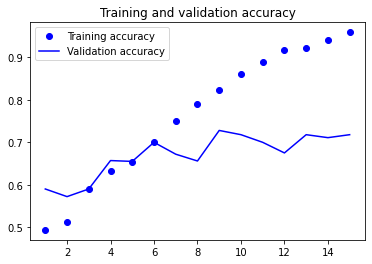

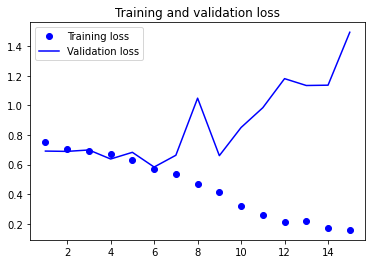

In [292]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [293]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 1s 7ms/step - loss: 0.6051 - accuracy: 0.7015
Test accuracy: 0.701


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [294]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

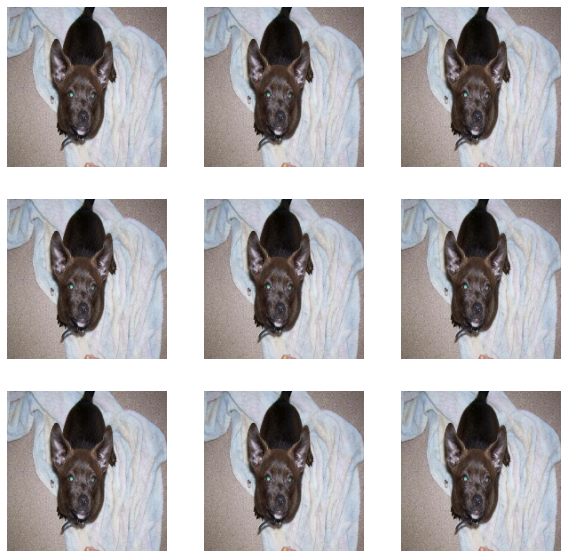

In [295]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [297]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [298]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=120,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/120
125/125 [==============================] - 4s 24ms/step - loss: 0.8054 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/120
125/125 [==============================] - 3s 22ms/step - loss: 0.7027 - accuracy: 0.5225 - val_loss: 0.6964 - val_accuracy: 0.5000
Epoch 3/120
125/125 [==============================] - 3s 22ms/step - loss: 0.7154 - accuracy: 0.5245 - val_loss: 0.7172 - val_accuracy: 0.5040
Epoch 4/120
125/125 [==============================] - 3s 23ms/step - loss: 0.7268 - accuracy: 0.5700 - val_loss: 0.6631 - val_accuracy: 0.6440
Epoch 5/120
125/125 [==============================] - 3s 22ms/step - loss: 0.6736 - accuracy: 0.6240 - val_loss: 0.8707 - val_accuracy: 0.5650
Epoch 6/120
125/125 [==============================] - 3s 24ms/step - loss: 0.6624 - accuracy: 0.6340 - val_loss: 0.6173 - val_accuracy: 0.6510
Epoch 7/120
125/125 [==============================] - 3s 23ms/step - loss: 0.6350 - accuracy: 0.6500 - val_loss: 0.5817 - val_accuracy:

**Evaluating the model on the test set**

In [299]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 1s 7ms/step - loss: 0.4769 - accuracy: 0.8105
Test accuracy: 0.811


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [300]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [301]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [302]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 20ms/step


In [303]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [308]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="relu")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=22,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/22
63/63 [==============================] - 1s 8ms/step - loss: 7.5879 - accuracy: 0.5020 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 2/22
63/63 [==============================] - 0s 4ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/22
63/63 [==============================] - 0s 4ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 4/22
63/63 [==============================] - 0s 4ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 5/22
63/63 [==============================] - 0s 4ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 6/22
63/63 [==============================] - 0s 5ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 7/22
63/63 [==============================] - 0s 4ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 8/22
63/63 [==

**Plotting the results**

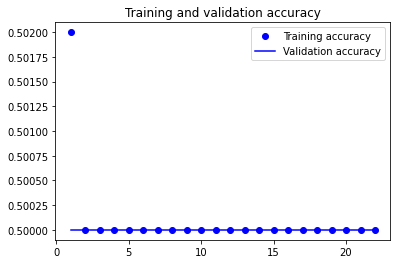

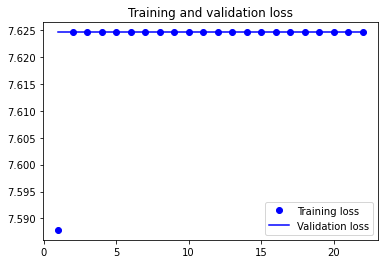

In [309]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [310]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [311]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [312]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [313]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [314]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=22,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/22
125/125 [==============================] - 5s 30ms/step - loss: 13.2090 - accuracy: 0.9130 - val_loss: 4.7360 - val_accuracy: 0.9670
Epoch 2/22
125/125 [==============================] - 4s 28ms/step - loss: 7.5996 - accuracy: 0.9460 - val_loss: 2.6320 - val_accuracy: 0.9790
Epoch 3/22
125/125 [==============================] - 3s 26ms/step - loss: 7.7776 - accuracy: 0.9475 - val_loss: 3.8865 - val_accuracy: 0.9770
Epoch 4/22
125/125 [==============================] - 3s 26ms/step - loss: 5.8465 - accuracy: 0.9635 - val_loss: 6.0392 - val_accuracy: 0.9730
Epoch 5/22
125/125 [==============================] - 3s 26ms/step - loss: 5.5041 - accuracy: 0.9630 - val_loss: 5.0374 - val_accuracy: 0.9770
Epoch 6/22
125/125 [==============================] - 3s 26ms/step - loss: 4.3491 - accuracy: 0.9660 - val_loss: 4.3924 - val_accuracy: 0.9810
Epoch 7/22
125/125 [==============================] - 4s 28ms/step - loss: 4.2565 - accuracy: 0.9675 - val_loss: 4.8124 - val_accuracy: 0.978

**Evaluating the model on the test set**

In [315]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 2s 13ms/step - loss: 2.8167 - accuracy: 0.9745
Test accuracy: 0.975


### Fine-tuning a pretrained model

In [316]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [317]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [318]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=22,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/22
125/125 [==============================] - 6s 32ms/step - loss: 1.1191 - accuracy: 0.9790 - val_loss: 1.9529 - val_accuracy: 0.9820
Epoch 2/22
125/125 [==============================] - 4s 30ms/step - loss: 0.3765 - accuracy: 0.9915 - val_loss: 1.7974 - val_accuracy: 0.9780
Epoch 3/22
125/125 [==============================] - 4s 28ms/step - loss: 0.7381 - accuracy: 0.9845 - val_loss: 2.3677 - val_accuracy: 0.9810
Epoch 4/22
125/125 [==============================] - 4s 30ms/step - loss: 0.5650 - accuracy: 0.9875 - val_loss: 1.7102 - val_accuracy: 0.9800
Epoch 5/22
125/125 [==============================] - 4s 28ms/step - loss: 0.4148 - accuracy: 0.9870 - val_loss: 1.8268 - val_accuracy: 0.9800
Epoch 6/22
125/125 [==============================] - 4s 28ms/step - loss: 0.3998 - accuracy: 0.9890 - val_loss: 1.7611 - val_accuracy: 0.9820
Epoch 7/22
125/125 [==============================] - 4s 31ms/step - loss: 0.4021 - accuracy: 0.9880 - val_loss: 1.4937 - val_accuracy: 0.9840

In [319]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 2s 12ms/step - loss: 1.7542 - accuracy: 0.9750
Test accuracy: 0.975
